In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import copy
import matplotlib
%matplotlib inline
sys.path.append("..")
from demo_2_awac import och_2_awac
import adept_envs
import gym

# Load in the data
all_paths = 'demo_list_3elements_KNOBCABINETSLIDER_deltapos_noredundancy_smallernoise_rewardfixed_newcode.pkl'

paths = pickle.load(open(all_paths, 'rb'))
import itertools

def check_goal_completion(curr_pos):
    max_objs = np.array([0.27, 0.7, -0.1])
    min_objs = np.array([0.07, 0.1, -0.275])
    init_bitflips = np.array([0, 0, 0])
    curr_bitflips = init_bitflips.copy()
    if len(curr_pos.shape) > 1:
        curr_pos = curr_pos.squeeze(axis=0)
    for j in range(3):
        if curr_pos[j] > max_objs[j]:
            curr_bitflips[j] = 1
        elif curr_pos[j] < min_objs[j]:
            curr_bitflips[j] = 0
    new_idx = 4 * curr_bitflips[0] + 2 * curr_bitflips[1] + curr_bitflips[2]
    return new_idx

input_x = []
for path in paths:
    input_x.append(path['observations'][:-100])
input_x = np.concatenate(input_x, axis=0)[:, 2:5]

input_y = []
start_idxs = []
end_idxs = []
# Get labels
prev_idx = -1
curr_idx = -1
window = 4
state_final_goal_nextgoal_tuples = []

continuous_paths = []
curr_continuous = []
idx_vals = [[] for _ in range(8)]
for j, path in enumerate(paths):
    curr_idx = check_goal_completion(path['observations'][0, 2:5])
    if curr_idx != prev_idx and prev_idx != -1:
        continuous_paths.append(curr_continuous)
        curr_continuous = []
    curr_continuous.append(path)
    prev_idx = check_goal_completion(path['observations'][-1, 2:5])    
    idx_vals[prev_idx].append(path['observations'][-1, 2:5])
continuous_paths.append(curr_continuous)

In [3]:
delta_skip = 6
state_nextgoal_finalgoal_tuples = []
for curr_continuous in continuous_paths:
    for j, path in enumerate(curr_continuous):
        leftover_skips = min(len(curr_continuous) - j, delta_skip)
        for k in range(len(path['observations']) - 100):
            for skips in range(leftover_skips):
                curr_ng = check_goal_completion(path['observations'][-1, 2:5]) 
                final_ng = check_goal_completion(curr_continuous[j + skips]['observations'][-1, 2:5]) 
                snf_tuple = (path['observations'][k][:8], curr_ng, final_ng)
                state_nextgoal_finalgoal_tuples.append(snf_tuple)

In [4]:
state_nextgoal_finalgoal_tuples

[(array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911598e-323,  7.74064031e-094, -5.03576989e-002,
          5.97946344e-002,  2.62392376e+000]),
  3,
  3),
 (array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911598e-323,  7.74064031e-094, -5.03576989e-002,
          5.97946344e-002,  2.62392376e+000]),
  3,
  1),
 (array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911598e-323,  7.74064031e-094, -5.03576989e-002,
          5.97946344e-002,  2.62392376e+000]),
  3,
  5),
 (array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911598e-323,  7.74064031e-094, -5.03576989e-002,
          5.97946344e-002,  2.62392376e+000]),
  3,
  4),
 (array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911598e-323,  7.74064031e-094, -5.03576989e-002,
          5.97946344e-002,  2.62392376e+000]),
  3,
  6),
 (array([ 3.99792804e-002,  4.00001729e-002,  2.85519475e-002,
         -8.39911

In [5]:
input_x = []
for snf_tuple in state_nextgoal_finalgoal_tuples:
    input_x.append([np.concatenate([snf_tuple[0][2:5], [snf_tuple[2]]])])
input_x = np.concatenate(input_x, axis=0)

input_y = []
for snf_tuple in state_nextgoal_finalgoal_tuples:
    input_y.append(snf_tuple[1])
input_y = np.array(input_y)

In [6]:
input_x.shape

(103704, 4)

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from rlkit.torch.networks import ConcatMlp, Mlp
import torch
import torch.nn as nn
input_size = 4
num_goals = 8
batch_size = 32


goal_predictor = Mlp(
    input_size=input_size,
    output_size=num_goals,
    hidden_sizes=(256, 256, 256),
)

optimizer = torch.optim.Adam(goal_predictor.parameters())

idxs_data = np.array(range(len(input_x)))
np.random.shuffle(idxs_data)
num_train = int(0.9*len(idxs_data))

input_x_train = input_x[idxs_data[:num_train]]
input_x_test = input_x[idxs_data[num_train:]]

input_y_train = input_y[idxs_data[:num_train]]
input_y_test = input_y[idxs_data[num_train:]]

# TODO: Check the syntax
train_ds = TensorDataset(torch.Tensor(input_x_train), torch.Tensor(input_y_train).long())
test_ds = TensorDataset(torch.Tensor(input_x_test), torch.Tensor(input_y_test).long())

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()

In [8]:
num_epochs = 10
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = goal_predictor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            outputs = goal_predictor(torch.Tensor(input_x_test))
            accuracy = np.sum(np.argmax(outputs.detach().numpy(), axis=1) == np.array(input_y_test, dtype=np.int32))/len(input_x_test)
#             print('TEST %f \n'%accuracy*100)
            

print('Finished Training')

[1,     1] loss: 0.00103980
[1,   101] loss: 0.10217457
[1,   201] loss: 0.08671189
[1,   301] loss: 0.06495834
[1,   401] loss: 0.05575236
[1,   501] loss: 0.05352627
[1,   601] loss: 0.05348855
[1,   701] loss: 0.05300002
[1,   801] loss: 0.05243337
[1,   901] loss: 0.05207906
[1,  1001] loss: 0.05274175
[1,  1101] loss: 0.05291163
[1,  1201] loss: 0.05186429
[1,  1301] loss: 0.05135623
[1,  1401] loss: 0.05163717
[1,  1501] loss: 0.05125491
[1,  1601] loss: 0.05085593
[1,  1701] loss: 0.05059532
[1,  1801] loss: 0.05051294
[1,  1901] loss: 0.05057148
[1,  2001] loss: 0.05010700
[1,  2101] loss: 0.05025725
[1,  2201] loss: 0.05090661
[1,  2301] loss: 0.04959044
[1,  2401] loss: 0.04997318
[1,  2501] loss: 0.05045465
[1,  2601] loss: 0.04874331
[1,  2701] loss: 0.04945052
[1,  2801] loss: 0.04938030
[1,  2901] loss: 0.04951061
[2,     1] loss: 0.00045608
[2,   101] loss: 0.04990031
[2,   201] loss: 0.04972589
[2,   301] loss: 0.04986660
[2,   401] loss: 0.04953989
[2,   501] loss: 0.0

[10,  2201] loss: 0.03724370
[10,  2301] loss: 0.03572498
[10,  2401] loss: 0.03656701
[10,  2501] loss: 0.03845157
[10,  2601] loss: 0.03666847
[10,  2701] loss: 0.03680725
[10,  2801] loss: 0.03824377
[10,  2901] loss: 0.03720929
Finished Training


In [9]:
start = 7
curr_s = idx_vals[start][np.random.randint(len(idx_vals[start]))]
curr_g = 5

pl = []
print("STARTING AT %d"%start)
for k in range(100):
    start = 7
    curr_s = idx_vals[start][np.random.randint(len(idx_vals[start]))]
    curr_g = 5
    print("============")
    for j in range(7):
        o = np.concatenate([curr_s, [curr_g]])
        o = torch.Tensor(o)
        prediction = torch.nn.Softmax()(goal_predictor(o)).detach().numpy()
        next_idx = np.random.choice(range(8), p =prediction)
        print("GOING TO %d"%next_idx)
        curr_s = idx_vals[next_idx][np.random.randint(len(idx_vals[next_idx]))]
        if next_idx == curr_g:
            break
    pl.append(j + 1)
    
np.array(pl).mean()

STARTING AT 7
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 5
GOING T

/usr/local/google/home/abhishekunique/anaconda3/envs/softlearning/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


1.8

In [10]:
torch.save(goal_predictor, 'BC_model_3elems_window6.pkl')

In [11]:
dat = torch.load('BC_model_3elems_window6.pkl')

In [12]:
goal_predictor.load_state_dict(dat.state_dict())

<All keys matched successfully>

In [10]:
import gym
import adept_envs
env = gym.make('franka_knob_cabinet_slider_resetfree_newcode-v1')
pl = []
tpl = []
pl_dict = {0: [], 1: [], 2: [], 3: [], 4: []}
print("STARTING AT %d"%start)
max_tries = 7
for k in range(10000):
    start = np.random.randint(8)
    curr_s = idx_vals[start][np.random.randint(len(idx_vals[start]))]
    curr_idx = start
    curr_g = start
    while curr_g == start:
        curr_g = np.random.randint(8)
    true_pathlength = len(env.env.compute_path(start)[curr_g]) - 1
    print("============")
    curr_pathlength = 0
    while curr_idx != curr_g and curr_pathlength < max_tries:
        o = np.concatenate([curr_s, [curr_g]])
        o = torch.Tensor(o)
        prediction = torch.nn.Softmax()(goal_predictor(o)).detach().numpy()
        next_idx = np.random.choice(range(8), p =prediction)
        print("GOING TO %d"%next_idx)
        curr_s = idx_vals[next_idx][np.random.randint(len(idx_vals[next_idx]))]
        curr_idx = next_idx
        curr_pathlength += 1
        
    pl.append(curr_pathlength)
    tpl.append(true_pathlength)
    pl_dict[true_pathlength].append(curr_pathlength)

STARTING AT 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING T

/usr/local/google/home/abhishekunique/anaconda3/envs/softlearning/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 6

GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 0
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4

GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0

GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7

GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0

GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 0
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 1

GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1

GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6

GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 6

GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 6
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5

GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 1
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7

GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 2
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 6

GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3

GOING TO 3
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 5

GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5

GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0

GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 1
GOING TO 3

GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7

GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 0

GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 0
GOING TO 0
GOING TO 6
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 7

GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0

GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 0

GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7

GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2

GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5

GOING TO 2
GOING TO 0
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3

GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 0

GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 3
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6

GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 2
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 0

GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 7
GOING TO 5

GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 1
GOING TO 4

GOING TO 1
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 5
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 7

GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5

GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6

GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 3
GOING TO 1

GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5

GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7

GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 7

GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6

GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4

GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3

GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 5

GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 7
GOING TO 5

GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6

GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0

GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 3
GOING TO 1

GOING TO 6
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 7
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5

GOING TO 5
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7

GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 6

GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6

GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 1
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4

GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 5

GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4

GOING TO 6
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 5
GOING TO 4
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3

GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 1
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6

GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 0
GOING TO 7
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 3
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 4

GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 3
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 6
GOING TO 7
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 2
GOING TO 6
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4

GOING TO 3
GOING TO 2
GOING TO 0
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 6
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 7
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 1
GOING TO 0
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 6
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 4
GOING TO 4
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6

GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 3
GOING TO 4
GOING TO 3
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 7
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 2
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 2
GOING TO 0

GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 3
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 2
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 4
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 2
GOING TO 6
GOING TO 6
GOING TO 6
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 0
GOING TO 6
GOING TO 6
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7

GOING TO 5
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 1
GOING TO 3
GOING TO 1
GOING TO 0
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 6
GOING TO 4
GOING TO 3
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 7
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 6
GOING TO 0
GOING TO 5
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 1
GOING TO 3
GOING TO 7
GOING TO 6
GOING TO 4
GOING TO 0
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 1
GOING TO 5
GOING TO 4
GOING TO 5
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 6
GOING TO 7
GOING TO 5
GOING TO 4
GOING TO 4
GOING TO 5
GOING TO 1
GOING TO 0
GOING TO 4
GOING TO 5
GOING TO 4
GOING TO 2
GOING TO 0
GOING TO 1
GOING TO 4
GOING TO 6
GOING TO 7

In [11]:
print(np.mean(pl_dict[1]))
print(np.mean(pl_dict[2]))
print(np.mean(pl_dict[3]))


3.3669962335216574
4.666510648256494
5.352941176470588


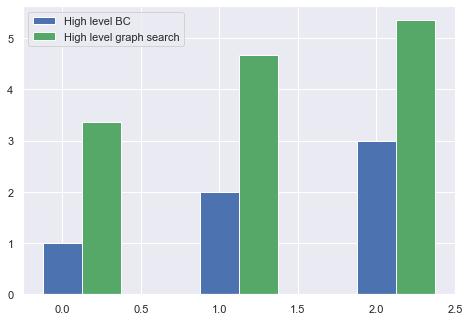

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, [1, 2, 3], color = 'b', width = 0.25, label='High level BC')
ax.bar(X + 0.25, [np.mean(pl_dict[1]), np.mean(pl_dict[2]), np.mean(pl_dict[3])], color = 'g', width = 0.25, label='High level graph search')
plt.legend()
plt.savefig('graphsearch_BC_pathlength_comparison.png')